In [1]:
install.packages("tidyverse")
library(ggplot2)
library(tidyverse)
library(tidymodels)
library(gridExtra)
install.packages("kknn")
options(repr.matrix.max.rows=10)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ─

In [2]:
url <- "https://raw.githubusercontent.com/Liam-ma06/DSCI_Project_final_report/refs/heads/main/players.csv"

player <- read_csv(url, show_col_types=FALSE) |>
    mutate(Age=as.numeric(Age))|>
    mutate(played_hours=as.numeric(played_hours))|>
    mutate(subscribe=as_factor(subscribe))|>
    drop_na(Age, played_hours, subscribe)

player_proportions <- player|>
    group_by(subscribe)|>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(player))
player_proportions
    
    

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


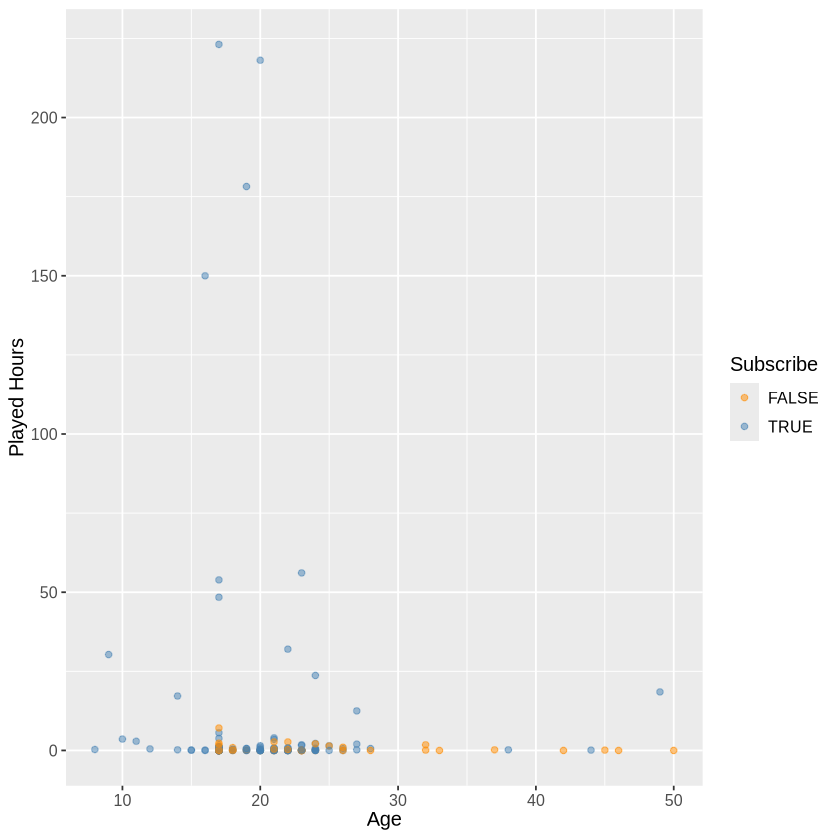

In [3]:
player_graph <- player|>
    ggplot(aes(x=Age, y=played_hours, color=subscribe))+
    geom_point(alpha=0.5)+
    labs(x="Age", y="Played Hours", color="Subscribe")+
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(text = element_text(size = 12))
player_graph
    

In [4]:
player_split <- initial_split(player, prop=0.75, strata=subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

In [5]:
player_proportions1 <- player_train|>
    group_by(subscribe)|>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(player_train))
player_proportions1
    

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


In [6]:
set.seed(123)

player_recipe <- recipe(subscribe ~ Age + played_hours, data=player_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("classification")

player_vfold <- vfold_cv(player_train, v=5, strata=subscribe)

knn_results <- workflow()|>
    add_recipe(player_recipe)|>
    add_model(knn_tune)|>
    tune_grid(resamples = player_vfold, grid=tibble(neighbors=seq(from=1, to=50, by=2)))|>
    collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4204598,5,0.04695286,Preprocessor1_Model01
1,roc_auc,binary,0.4329545,5,0.05568129,Preprocessor1_Model01
3,accuracy,binary,0.4770608,5,0.04356948,Preprocessor1_Model02
3,roc_auc,binary,0.5214711,5,0.02809583,Preprocessor1_Model02
5,accuracy,binary,0.5729392,5,0.03385628,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,roc_auc,binary,0.6255141,5,0.036243911,Preprocessor1_Model23
47,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model24
47,roc_auc,binary,0.6337044,5,0.049077954,Preprocessor1_Model24


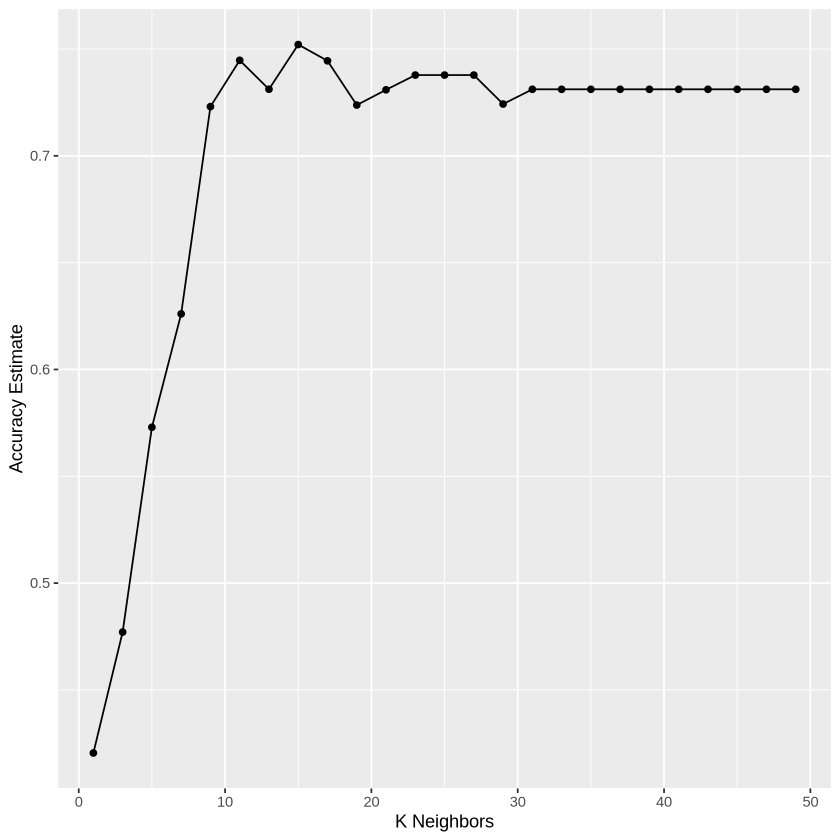

In [7]:
accuracies <- knn_results |>
    filter(.metric=="accuracy")|>
    mutate(mean=as.numeric(mean), neighbors=as.numeric(neighbors))

K_accuracy_plot <- accuracies |>
    ggplot(aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    labs(x="K Neighbors", y="Accuracy Estimate")
K_accuracy_plot

In [9]:
best_accuracy <- accuracies |>
  filter(mean == max(mean))
best_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.7521018,5,0.02207079,Preprocessor1_Model08


In [12]:

set.seed(1234)


knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
  set_engine("kknn") |>
  set_mode("classification")

# 2. Create the workflow
knn_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  fit(data = player_train)


player_predictions <- knn_fit |>
  predict(player_test) |>
  bind_cols(player_test)


player_accuracy <- player_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()


player_accuracy

[1] 0.755102

In [14]:
confusion_matrix <- player_predictions|>
    conf_mat(truth=subscribe, estimate=.pred_class)
confusion_matrix

          Truth
Prediction FALSE TRUE
     FALSE     1    0
     TRUE     12   36